# 30860 - Cognitive Systems: Theory and Methods

##### Author: R. Zucca (IBEC Barcelona)

Last modified: March 1st 2019




# 01. EEG Preprocessing workflow

When working with EEG data the following preprocessing steps are recommeneded:

- Import the raw data 
- Identify bad channels
- The data has to be filtered to the desired passband
- Common artifacts should be suppressed (using visual inspection or automatized techniques)
- Segment your data into epochs

In this tutorial we'll work with a 5 minutes long EEG recording from a subject resting with his eyes closed one week after a head injury.  Data were acquired using a dry electrode clinical headset (Quasar Wearable Sensing, DSI-24), recording at a sampling rate of 300 Hz and using 21 electrodes placed according to the International 10-20 system.

Electrode Pz served as the common reference. Three additional electrodes were used to record EOG, EKG and EMG from the right forearm.

## Import the necessary libraries

Throughout this tutorial we will make essentially use of three libraries:

- MNE (see mne-tools.github.io for documentation), an open-source Python library for exploring, visualizing and analysing electrophysiological data
- Numpy
- matplotlib

In [1]:
# Import the libraries
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__
import xdf

# We want to use interactive plots from MNE so we'll set %matplotlib to use the 'notebook' backend 
%matplotlib notebook

# We want to get rid off unnecessary warning messages
mne.set_log_level('WARNING')

# We set the family and the size of the font characters for pretty looking plots
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

In [2]:
# Check the version of the used libraries 
print('MNE version: {}'.format(mne.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Matplotlib version: {}'.format(__version__))

MNE version: 0.17.0
Numpy version: 1.15.4
Matplotlib version: 3.0.2


### Parameters

As a first step we define some parameters that we'll use at different stages of the preprocessing.

In [3]:
!pwd

/Users/annachesson/Desktop/MNEPractice/EEGprep


In [4]:
# Set the path to your dataset (POINT TO THE FOLDER WHERE YOU STORED YOUR DATASET)
datapath   = './EEGPrep'

# Select the subject you want to preprocess (in this case we have a single dataset in our data folder called 'example')
id_subject = '007_01_EC' 
filename   = id_subject + '_raw.set'

# Let's set some output files to later save our data
save_to_output      = datapath + id_subject + '-epo.fif'
save_to_output_ica  = datapath + id_subject + '_ica-epo.fif'



MAYBE APPLICABLE FOR US->
As a next step, we want to divide our 5 min dataset into segments (or epochs) that are 4 sec long. So we define the start and end points of our epochs.

And we define the limits of the lower and higher frequencies to filter our signal.

In [5]:
# Band pass filter (Power-line is 60 Hz)
low_freq  = 1.0
high_freq = 50.0

#### Read data into MNE
MNE offers different ways to import and read your data. Depending on the acquisition system that has been used to collect the data you will need to use one of the following: `read_raw_fif`, `read_raw_kit`, `read_raw_bti`, `read_raw_ctf`, `read_raw_brainvision`, `read_raw_cnt`, `read_raw_edf`, `read_raw_eeglab`, `read_raw_egi`, `read_raw_nicolet`.

Since our data have been saved using the eeglab system we will use `read_raw_eeglab` to import our dataset, which will return a `mne.io.Raw` like object.

# our eeg information arrives in an xdf file, so first we must convert this to a csv (then later pandas dataframe, and after that, raw mne object)

In [6]:
#read raw data from xdf file
import numpy as np
import pandas as pd
import sys
sys.path.append("./Python")
import xdf
import pyxdf

In [7]:
#this function is the original exportStream function which when used with the stream names
#'openvibeMarkers' or 'UnityData Stram' creates a csv 'stimulus_events.csv' 
#containing the marker information needed for the STIM channel

def originalexportStream(file_path, stream_name, markers_stream_name=None, subject_number=None, markers_to_write=None):
    """
    file_path -- path to the XDF file
    stream_name -- name of the stream (in the XDF file) that is going to be exported
    markers_stream_none -- name of the stream of markers, if any (optional)
    subject_number -- number of the subject, used only name the generated CSV file
    markers_to_write -- list of markers to be exported if only some are desired (if empty, all markers in markers_stream name will be exported)
    """
    streams = pyxdf.load_xdf(file_path)

    # Find the desired stream
    desired_stream = None
    for i in range (len(streams[0])):
        if streams[0][i]['info']['name'][0] == stream_name:
            desired_stream = streams[0][i]
            break
    
    if desired_stream is None:
        return "Stream " + stream_name + " not found"

    if markers_stream_name is not None and markers_stream_name is not '':
        # Put the data in array, row by row, with a place for the markers
        desired_stream_data = []
        for i in range(len(desired_stream['time_series'])):
            desired_stream_data.append([desired_stream['time_series'][i][0], 0, desired_stream['time_stamps'][i]])
        
        # Find the Marker data
        markers = None
        for i in range (len(streams[0])):
            if streams[0][i]['info']['name'][0] == markers_stream_name:
                markers = streams[0][i]
                break
        
        if markers is None:
            return "Markers stream " + markers_stream_name + " not found"

        # Define function for finding the nearest value in an array
        # Used to find the closest desired stream timestamp that matches the timestamp of each marker
        def find_nearest(array,value):
            idx = (np.abs(array-value)).argmin()
            return idx

        # Add the markers to right rows of desired stream data
        for i in range(len(markers['time_series'])):
            if markers_to_write == None or len(markers_to_write) == 0 or int(markers['time_series'][i]) in markers_to_write:
                index = find_nearest(desired_stream['time_stamps'], markers['time_stamps'][i])
                desired_stream_data[index][1] = int(markers['time_series'][i])

        # Create a dataframe with the desired stream data
        desired_stream_dataframe = pd.DataFrame(desired_stream_data, columns=[stream_name, 'Markers', 'Time'])
    else:
        # Put the data in array, row by row
        desired_stream_data = []
        for i in range(len(desired_stream['time_series'])):
            desired_stream_data.append([desired_stream['time_series'][i][0], desired_stream['time_stamps'][i]])
        
        # Create a dataframe with the desired stream data
        desired_stream_dataframe = pd.DataFrame(desired_stream_data, columns=[stream_name, 'Time'])

    # Save the desired stream dataframe to CSV
   # Save the desired stream dataframe to CSV
        desired_stream_dataframe.to_csv("stimulus_events.csv", sep=';', index=False)
        print("File created successfully")

In [8]:
#this function is the modified exportStream function which when used with the
#stream name 'openvibeSignal' creates a csv 'untitled-test.csv' 
#containing the information of the time and 14 eeg channels data of emotiv device

streams = []
def emotivexportStream(file_path, stream_name, markers_stream_name=None, subject_number=None, markers_to_write=None):
    """
    file_path -- path to the XDF file
    stream_name -- name of the stream (in the XDF file) that is going to be exported
    markers_stream_none -- name of the stream of markers, if any (optional)
    subject_number -- number of the subject, used only name the generated CSV file
    markers_to_write -- list of markers to be exported if only some are desired (if empty, all markers in markers_stream name will be exported)
    """
    streams = pyxdf.load_xdf(file_path)
    
    # Find the desired stream
    desired_stream = None
    for i in range (len(streams[0])):
        if streams[0][i]['info']['name'][0] == stream_name:
            desired_stream = streams[0][i]
            break
    
    if desired_stream is None:
        return "Stream " + stream_name + " not found"

    if markers_stream_name is not None and markers_stream_name is not '':
        # Put the data in array, row by row, with a place for the markers
        desired_stream_data = []
        for i in range(len(desired_stream['time_series'])):
            desired_stream_data.append([desired_stream['time_series'][i][0], 0, desired_stream['time_stamps'][i]])
        
        # Find the Marker data
        markers = None
        for i in range (len(streams[0])):
            if streams[0][i]['info']['name'][0] == markers_stream_name:
                markers = streams[0][i]
                break
        
        if markers is None:
            return "Markers stream " + markers_stream_name + " not found"

        # Define function for finding the nearest value in an array
        # Used to find the closest desired stream timestamp that matches the timestamp of each marker
        def find_nearest(array,value):
            idx = (np.abs(array-value)).argmin()
            return idx

        # Add the markers to right rows of desired stream data
        for i in range(len(markers['time_series'])):
            if markers_to_write == None or len(markers_to_write) == 0 or int(markers['time_series'][i]) in markers_to_write:
                index = find_nearest(desired_stream['time_stamps'], markers['time_stamps'][i])
                desired_stream_data[index][1] = int(markers['time_series'][i])

         # Create a dataframe with the desired stream data
        desired_stream_dataframe = pd.DataFrame(desired_stream_data, columns=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"])
    else:
        # Put the data in array, row by row
        desired_stream_data = []
        #for i in range(len(desired_stream['time_series'])):
            #desired_stream_data.append([desired_stream['time_series'][i][0], desired_stream['time_stamps'][i]])
            
        for i in range(len(desired_stream['time_series'])):
            desired_stream_data.append([desired_stream['time_stamps'][i], desired_stream['time_series'][i][0], 
                                        desired_stream['time_series'][i][1], desired_stream['time_series'][i][2], 
                                        desired_stream['time_series'][i][3], desired_stream['time_series'][i][4], 
                                        desired_stream['time_series'][i][5], desired_stream['time_series'][i][6], 
                                        desired_stream['time_series'][i][7], desired_stream['time_series'][i][8], 
                                        desired_stream['time_series'][i][9], desired_stream['time_series'][i][10],
                                       desired_stream['time_series'][i][11], desired_stream['time_series'][i][12],
                                       desired_stream['time_series'][i][13]])
        # Create a dataframe with the desired stream data
        desired_stream_dataframe = pd.DataFrame(desired_stream_data, columns=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"])

    # Save the desired stream dataframe to CSV
    desired_stream_dataframe.to_csv("untitled-test.csv", sep=';', index=False)
    print("File created successfully")

In [9]:
#emotivexportStream  reads xdf file, 
#creates csv titled "untitled-test.csv" with time and EEG channel information
#when used with stream name "openvibeSignal"
emotivexportStream("test3.xdf", "openvibeSignal")

File created successfully


In [ ]:
#load_xdf() displays information about the structure of the XDF file
#pyxdf.load_xdf("test3.xdf")

(60, 70)

/Users/annachesson/anaconda3/envs/mne/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


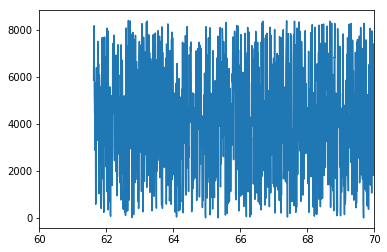

In [10]:
#create a pandas dataframe from the 'untitled-test.csv' containing time and EEG information
#for the 14 emotiv channels. This dataframe is not used directly in the process to convert to 
#our csv file to raw mne object, however:
#pandas dataframes allows easier exploration of the data with .shape, .head, and .describe()

datacsv = pd.read_csv('untitled-test.csv', sep=';')
plt.plot(datacsv['0'], datacsv['1'])
plt.xlim([60, 70])
#plt.xlim([960, 965]) #Focus on a smaller epoch

# now the 'untitled-test.csv' is converted into  raw mne object with time and data from the 14 channels of the emotiv

In [11]:
# Read the EEG CSV file as a NumPy array
data = np.loadtxt('untitled-test.csv', delimiter=';')
#ch_types variable must contain same number of elements as csv columns/emotiv channels
ch_types = ch_types = ['eeg'] * 15
# Some information about the channels
ch_names = ['time','CH 1','CH 2', 'CH 3', 'CH 4', 'CH 5', 'CH 6', 'CH 7', 'CH 8', 'CH 9', 'CH 10', 'CH 11', 'CH 12', 'CH 13', 'CH 14']

# Sampling rate of the emotiv device
sfreq = 128  # Hz

# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq, ch_types = ch_types)

# Finally, create the Raw object, transposing the data array
EEG = mne.io.RawArray(data.T, info)

/Users/annachesson/anaconda3/envs/mne/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


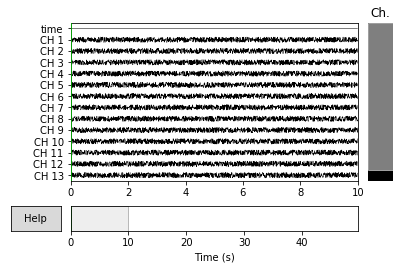

(60, 70)

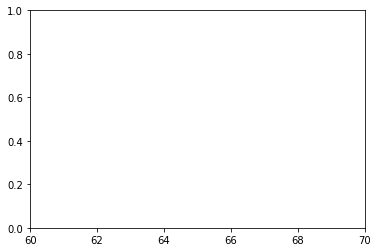

In [12]:
#plotting raw mne object
# It is also possible to auto-compute scalings
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
EEG.plot(n_channels=14, scalings=scalings, title='Data from Emotiv', show=True, block=True)
plt.xlim([60, 70])

In [13]:
# Let's print some information about the data
print('Sampling rate: {} Hz'.format(EEG.info['sfreq']))
print('Channels: {}'.format(EEG.info['ch_names']))
print('Total number of channels: {}'.format(EEG.info['nchan']))

Sampling rate: 128.0 Hz
Channels: ['time', 'CH 1', 'CH 2', 'CH 3', 'CH 4', 'CH 5', 'CH 6', 'CH 7', 'CH 8', 'CH 9', 'CH 10', 'CH 11', 'CH 12', 'CH 13', 'CH 14']
Total number of channels: 15


Check that the names of the channels are consistent across the different subjects you recorded.

As an example we konw that for other subjects recorded during this study electrodes `M1` and `M2` have been called `A1` and `A2`. In those cases we need to rename the channels in this way:

`EEG.rename_channels({'A1':'M1', 'A2':'M2'})`

#### Inspect your data

You can now visually inspect your data with the plotting tools provided by MNE

<IPython.core.display.Javascript object>


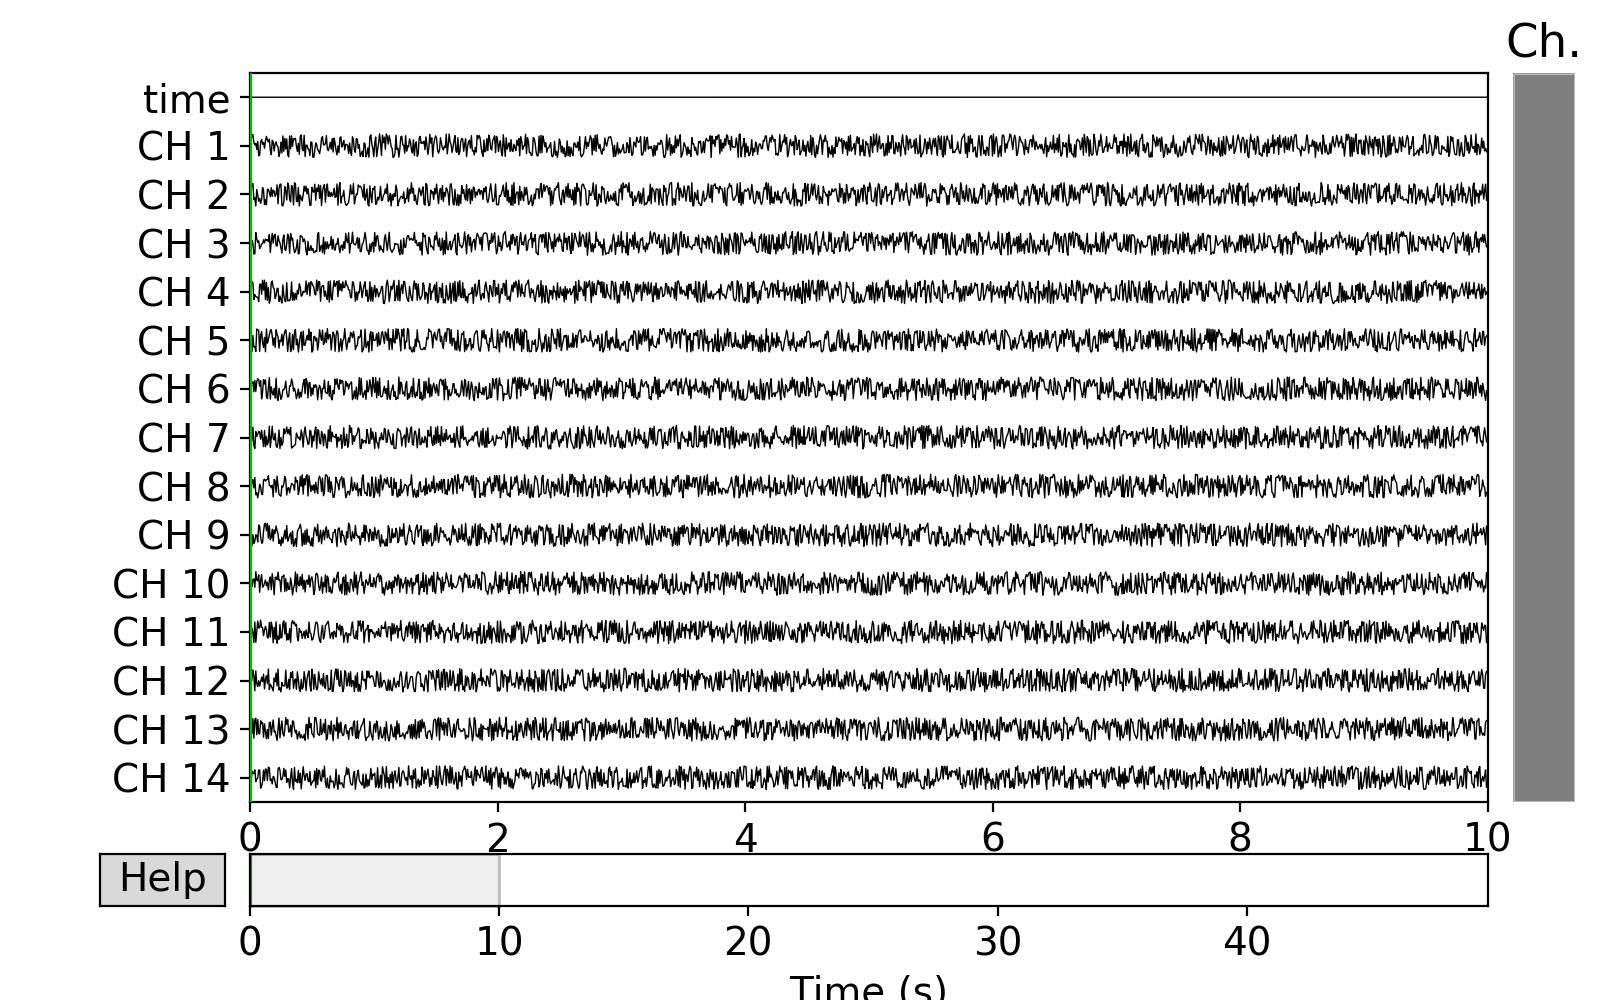

In [14]:
%matplotlib notebook
n_channels = 15
duration = 10 # Time in sec you want to visualize in the window

f = EEG.plot(n_channels=n_channels, remove_dc=True, highpass=low_freq, lowpass=high_freq, 
         scalings='auto', duration=duration, show=False);
f.set_size_inches(8,5)

#### Define the events for epoching your data
In MNE, epochs refers to a collection of single trials or short segments of time locked raw data. In general, to create time locked epochs, we first need a set of events that contain the information about the times. 
Those events are usually stored in the stimulus channel, which is used to store the time of occurrence of specific events during a study (i.e., the presentation of a visual stimulus, the response of a suvbject, etc.).

You can also create an event list from raw data, by calling a function dedicated just for that. Since the event list is simply a numpy array, you can also manually create one. If you create one from an outside source (like a separate file of events), pay special attention in aligning the events correctly with the raw data.

Since we just recorded the data in a resting state condition and we don't have specific events, we'll manually create a series of dummy events to align our epochs.

# Create stimulus channel
#dummy events (marked with the code 1000) for epoching
epoch_length_sec = 4
epoch_length = np.int(epoch_length_sec*EEG.info['sfreq'])
info         = mne.create_info(['STI'], EEG.info['sfreq'], ['stim'])
stim_data    = np.zeros((1, len(EEG.times)))

stim_data[0,epoch_length:-2*epoch_length:epoch_length] = 1000.
                 
#Make a new channel 
stim_raw     = mne.io.RawArray(stim_data, info) # This creates a new Raw data array
EEG.add_channels([stim_raw], force_update_info=True) # This adds the channel to the dataset

In [58]:
#now we have to add a stimulus channel to our EEG raw object. the STIM channel is a 2d
#array which should be the same length as the time data in our EEG raw object (EEG.times)
#we initialize it as an empty array first, so we can add it to our EEG raw object with add_channel
#Then later we will be able to add events to it

#create empty stim_data array, not sure if this is correct dimension
stim_data = np.zeros((len(EEG.times), 1))

#like before we must take the resulting stim_data array create a raw mne object
#to prepare to add it to our previous EEG raw object

#ch_types variable must contain same number of elements as csv columns/marker info
#question: what type and what dimension? 2d array?
ch_types = ch_types = ['eeg'] * 1

# Some information about the channels
ch_names = ['markers']

# Sampling rate of the emotiv device
sfreq = 128  # Hz

# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq, ch_types = ch_types)

# Finally, create the Raw object
stim_raw = mne.io.RawArray(stim_data.T, info)

In [59]:
EEG.add_channels([stim_raw], force_update_info=True) # This adds the channel to the dataset


<RawArray  |  None, n_channels x n_times : 16 x 6357 (49.7 sec), ~829 kB, data loaded>

In [60]:
#originalexportStream when used with stream name 'openvibeMarkers' or 'UnityData Stram'
#creates csv 'stimulus_events.csv' containing the event marers
originalexportStream('test3.xdf', 'UnityData Stram')

File created successfully


In [61]:
#create a pandas dataframe from the 'stimulus_events.csv' containing time and EEG information
#for the 14 emotiv channels. This dataframe is not used directly in the process to convert to 
#our csv file to raw mne object, however:
#pandas dataframes allows easier exploration of the data with .shape, .head, and .describe()
stim_datacsv = pd.read_csv('stimulus_events.csv', sep=';')


In [62]:
stim_datacsv.head

<bound method NDFrame.head of   UnityData Stram       Time
0    PressedLow_1  50.075241
1    RewardNone_1  59.142137
2    PressedLow_2  64.137987
3    RewardNone_2  73.267894
4   PressedHigh_3  81.506986
5    RewardNone_3  86.891905>

# now can we add events to the stimulus channel from one of our marker streams csv files? using EEG.add_events?

# ASK RICCARDO WHAT AND WHERE A MONTAGE SHOULD BE, HOW TO CREATE A MONTAGE FILE 

#### Montage

We set the electrodes position using the available montage. In this case we use the standard International 10-20 system.

In [ ]:
# Read the montage
montage = mne.channels.read_montage('eeg', ['time','CH 1 , CH 2, CH 3, CH 4, CH 5, CH 6, CH 7, CH 8, CH 9, CH 10, CH 11, CH 12, CH 13, CH 14'], '/users/annachesson/desktop/MNEPractice/EEGPrep')

# Apply the montage
EEG.set_montage(montage)

# Select only the needed electrodes (eeg and misc)
EEG.pick_types(meg=False, eeg=True, eog=False, ecg=False, misc=True, stim=True)

In [ ]:
# Plot channels location

fig_on = True
if fig_on:
    f = EEG.plot_sensors(ch_type='eeg', title=[], show_names=True, ch_groups='position', show=False)
    f.set_size_inches(4,4)
    f.savefig('S1_Channel_locs.png', dpi=300, format='png')

#### Filter your data
First we high-pass the data to remove slow drifts
Next, we can low-pass or band pass the data to extract the data in the frequency range we are interested to investigate.

If you are interested in looking at higher frequencies (above 50 Hz) you should remove the power-line noise (usually 50 Hz in Europe, and 60 Hz in the USA) applying a notch filter to cut off that specific frequencies and their harmonics.

In [ ]:
# Apply an high-pass filter to remove slow drifts
EEG.filter(0.5, None, fir_design='firwin2')

In [ ]:
# High-pass/Band pass filter (1/50 HZ)
EEG.filter(None, high_freq, fir_design='firwin2')

#### Remove bad channels
You can manually set a list of channels to be removed from the analysis. You can later interpolate those channels to run group analysis with the same data structure (number of channels) for all of your subjects.

In [ ]:
# Select bad channels
EEG.info['bads']

#### Re-reference your data
The data have been recorded with a reference in the Pz channel. We can re-reference the data to the average of the electrode.

In [ ]:
EEG_average_ref, _ = mne.set_eeg_reference(EEG, ref_channels='average', projection=False)

In [ ]:
# Interpolate bad channels
#if len(EEG.info['bads'])>0:
#    EEG_average_ref.interpolate_bads(reset_bads=True)

In [ ]:
f = EEG_average_ref.plot(start=0.0, n_channels=14, remove_dc=True, highpass=low_freq, lowpass=high_freq, 
                     scalings='auto', duration=50, show=False)
f.set_size_inches(8,5)

#### Plot the Power Spectrum Density 

In [ ]:
# Pick the channels you want to analyse and exclude
picks = mne.pick_types(EEG_average_ref.info, meg=False, eeg=True, misc=False, ecg=False, eog=False, stim=False, exclude='bads')

f = EEG_average_ref.plot_psd(area_mode='std', tmin=0.0, fmax=50., picks=picks, estimate='power',
                 average=False, n_jobs=-1, xscale='linear', show=False);
f.set_size_inches(6,5)

#### Define epochs

In [ ]:
# Read the events from the stimulation channel
events = mne.find_events(EEG_average_ref, stim_channel='STI', output='onset', shortest_event=1,
                         min_duration=1/EEG_average_ref.info['sfreq'])
print('Number of events found: %d' % len(events))

In [ ]:
print(events)

In [ ]:
# Here we set a threshold to reject bad epochs 
# Since these are resting data we can be more relaxed and exclude larger portions of noisy data
reject = dict(eeg=150e-6) 

# Here we can set the baseline correction (in this case we remove the average from all the epoch)
baseline = (None,None)

# Pick the channels you want to include 
picks = mne.pick_types(EEG_average_ref.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, misc=True, exclude=[])

# Epoch the data around event 1 (here defined as "trial_start")
epochs =  mne.Epochs(EEG_average_ref, events, tmin=tmin, tmax=tmax, 
                     baseline=baseline, preload=True, reject=reject)

# Check if all the epochs (nr of trials in the experiment) were extracted
print('Number of epochs: %d' % len(epochs))

In [ ]:
# Plot the epochs for inspection
picks = mne.pick_types(epochs.info,  meg=False, eeg=True, exclude='bads')

f = epochs.plot(show=False, title='', n_channels=26, picks=picks, n_epochs=3, scalings={'eeg':120*1e-6})
f.set_size_inches(12,8)

In [ ]:
# Plot the average PSD of the epoched data
f = epochs.plot_psd(2., 50., tmin=-1.5, tmax=1.5, n_jobs=-1, show=False);
f.set_size_inches(6,4)

## Remove the common artifacts from your data

### Artifact removal via Independent Component Analysis (ICA)

In [ ]:
# Set some parameters
method = 'fastica'
decim = 3 # You can downsample data to speed up computation
random_state = 23 # Set a seed random number to be able to reproduce the same results

In [ ]:
# Create an ICA object

reject = dict(eeg=150e-6)
ica = mne.preprocessing.ICA(n_components=.95, method=method, random_state=random_state, max_iter=400)
print(ica)

In [ ]:
# Fit the data to the ICA model
picks = mne.pick_types(epochs.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, exclude='bads')
ica.fit( epochs, reject=reject, picks=picks, decim=decim )

In [ ]:
# You can use an automatic detection artifacts algorithm 
# and add the ecg annd eog channels if available

ica.detect_artifacts(epochs, ecg_ch='X3')

print("Components to exclude: ")
print(ica.exclude)

In [ ]:
# Plot the components
ica.plot_components()

In [ ]:
# Plot the sources
f = ica.plot_sources(epochs, start=0, stop=5, picks=range(0,11), exclude=ica.exclude, show=False)
f.set_size_inches(12,8)

In [ ]:
# Inspect each component
pick_comp = [2]

f = ica.plot_properties(epochs, picks=pick_comp, psd_args={'fmax':40.}, plot_std=1.0, show=False)

#### Apply the ICA to your data

In [ ]:
# Apply the result of the ICA (remove only components for which you are sure they contain artifactual data)
ica.exclude = [0,2]

In [ ]:
epochs_ica = ica.apply(epochs.copy(), exclude=ica.exclude)

In [ ]:
# INterpolate bad channels, if any
if len(epochs_ica.info['bads'])>0:
    epochs_ica.interpolate_bads(reset_bads=True)

In [ ]:
picks = mne.pick_types(epochs_ica.info, meg=False, eeg=True, ecg=True, eog=False, stim=False, exclude='bads')

f = epochs_ica.plot(show=False, title='', n_channels=26, picks=picks, n_epochs=10, scalings={'eeg':100*1e-6})
f.set_size_inches(15,8)

In [ ]:
picks = mne.pick_types(epochs_ica.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, exclude='bads')
epochs_ica.plot_psd(2., 40., tmin=-1.5, tmax=1.5, n_jobs=-1);


### Save epochs

In [ ]:
epochs.save(save_to_output)
epochs_ica.save(save_to_output_ica)